In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


## 1. Import Packages

In [2]:
# dataset = np.loadtxt("/gdrive/My Drive/colab/TimeSeries/dataset/tuto1/)

import pandas as pd
import numpy as np
import fbprophet as ph
import matplotlib.pyplot as plt
import datetime
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

folderName  = "/gdrive/My Drive/colab/TimeSeries/dataset/tuto1"
fileName = "RefBldgHospitalNew.csv"
dataSource = folderName + "/" + fileName
print(dataSource)

dataset = pd.read_csv(dataSource)
dataset.shape

/gdrive/My Drive/colab/TimeSeries/dataset/tuto1/RefBldgHospitalNew.csv


(8760, 11)

In [3]:
dataset.head(5)

,Date/Time,Electricity:Facility [kW](Hourly),Fans:Electricity [kW](Hourly),Cooling:Electricity [kW](Hourly),Heating:Electricity [kW](Hourly),InteriorLights:Electricity [kW](Hourly),InteriorEquipment:Electricity [kW](Hourly),Gas:Facility [kW](Hourly),Heating:Gas [kW](Hourly),InteriorEquipment:Gas [kW](Hourly),Water Heater:WaterSystems:Gas [kW](Hourly)
0,01/01 01:00:00,780.505925,102.203354,391.580763,0.0,34.961655,113.31278,643.239183,628.856149,5.66467,8.718364
1,01/01 02:00:00,778.138589,102.203354,400.770817,0.0,34.961655,113.31278,655.744648,632.663475,5.66467,17.416503
2,01/01 03:00:00,787.421514,102.203354,403.860968,0.0,34.961655,113.31278,662.874018,639.794366,5.66467,17.414982
3,01/01 04:00:00,797.705194,102.203354,402.927995,0.0,34.961655,113.31278,660.449268,646.065868,5.66467,8.718730
4,01/01 05:00:00,807.032061,102.203354,400.204188,0.0,44.493766,113.31278,665.570284,642.488544,5.66467,17.417071


In [4]:
dataset.tail()

,Date/Time,Electricity:Facility [kW](Hourly),Fans:Electricity [kW](Hourly),Cooling:Electricity [kW](Hourly),Heating:Electricity [kW](Hourly),InteriorLights:Electricity [kW](Hourly),InteriorEquipment:Electricity [kW](Hourly),Gas:Facility [kW](Hourly),Heating:Gas [kW](Hourly),InteriorEquipment:Gas [kW](Hourly),Water Heater:WaterSystems:Gas [kW](Hourly)
8755,12/31 20:00:00,839.860122,102.203354,414.748257,0.0,44.493766,155.957040,571.600791,497.539086,56.646700,17.415005
8756,12/31 21:00:00,806.442742,102.203354,409.423754,0.0,44.493766,124.558693,602.008942,536.643496,56.646700,8.718746
8757,12/31 22:00:00,796.220841,102.203354,409.852635,0.0,44.493766,124.558693,604.129298,544.227192,42.485025,17.417081
8758,12/31 23:00:00,797.559528,102.203354,409.313899,0.0,34.961655,124.558693,614.845607,569.106824,28.323350,17.415433
8759,12/31 24:00:00,805.943727,102.203354,399.333715,0.0,34.961655,124.558693,606.437217,583.556565,14.161675,8.718977


In [5]:
dataset.columns

Index(['Date/Time', 'Electricity:Facility [kW](Hourly)',
       'Fans:Electricity [kW](Hourly)', 'Cooling:Electricity [kW](Hourly)',
       'Heating:Electricity [kW](Hourly)',
       'InteriorLights:Electricity [kW](Hourly)',
       'InteriorEquipment:Electricity [kW](Hourly)',
       'Gas:Facility [kW](Hourly)', 'Heating:Gas [kW](Hourly)',
       'InteriorEquipment:Gas [kW](Hourly)',
       'Water Heater:WaterSystems:Gas [kW](Hourly)'],
      dtype='object')

In [6]:
# Note : Ds = Date, y = Views
dataset = dataset[['Date/Time', 'Electricity:Facility [kW](Hourly)', 'Gas:Facility [kW](Hourly)']]

df_electric = dataset[['Date/Time', 'Electricity:Facility [kW](Hourly)']]
df_gas = dataset[['Date/Time',  'Gas:Facility [kW](Hourly)']]
print(df_electric.columns)
print(df_gas.columns)
df_electric.head()

Index(['Date/Time', 'Electricity:Facility [kW](Hourly)'], dtype='object')
Index(['Date/Time', 'Gas:Facility [kW](Hourly)'], dtype='object')


,Date/Time,Electricity:Facility [kW](Hourly)
0,01/01 01:00:00,780.505925
1,01/01 02:00:00,778.138589
2,01/01 03:00:00,787.421514
3,01/01 04:00:00,797.705194
4,01/01 05:00:00,807.032061


In [7]:
df_electric.tail()

,Date/Time,Electricity:Facility [kW](Hourly)
8755,12/31 20:00:00,839.860122
8756,12/31 21:00:00,806.442742
8757,12/31 22:00:00,796.220841
8758,12/31 23:00:00,797.559528
8759,12/31 24:00:00,805.943727


In [8]:
df_gas.head()

,Date/Time,Gas:Facility [kW](Hourly)
0,01/01 01:00:00,643.239183
1,01/01 02:00:00,655.744648
2,01/01 03:00:00,662.874018
3,01/01 04:00:00,660.449268
4,01/01 05:00:00,665.570284


In [9]:
df_electric.rename(columns={'Date/Time' : 'ds', 'Electricity:Facility [kW](Hourly)': 'y'}, inplace=True)
df_gas.rename(columns={'Date/Time': 'ds', 'Gas:Facility [kW](Hourly)' : 'y'}, inplace=True)
print(df_electric.columns)
print(df_gas.columns)

Index(['ds', 'y'], dtype='object')
Index(['ds', 'y'], dtype='object')


In [10]:
# Note This dataset belong to year 2004 
# If you try to use the "Ds" column as "datetime you will get the following error:
# Try:    df['Ds'] = pd.to_datetime(df['Ds'])
# Error:  OutOfBoundsDatetime: Out of bounds nanosecond timestamp: 1-01-01 01:00:00
#
# So we need to change this date properly to set the year.
# .index.map(lambda t: t.replace(year=2004))
#df['Ds'] = df['Ds'].replace(year=2004)
def modify_date(row):
    return row[:6] + '/2004' + row[6:].replace('24:', '00:')

df_electric['ds'] = df_electric['ds'].apply(modify_date)
df_gas['ds'] = df_gas['ds'].apply(modify_date)

print(df_electric['ds'].head())
print("=====================================")
print(df_gas['ds'].head())

0     01/01/2004  01:00:00
1     01/01/2004  02:00:00
2     01/01/2004  03:00:00
3     01/01/2004  04:00:00
4     01/01/2004  05:00:00
Name: ds, dtype: object
0     01/01/2004  01:00:00
1     01/01/2004  02:00:00
2     01/01/2004  03:00:00
3     01/01/2004  04:00:00
4     01/01/2004  05:00:00
Name: ds, dtype: object


In [11]:
df_electric.head()

,ds,y
0,01/01/2004 01:00:00,780.505925
1,01/01/2004 02:00:00,778.138589
2,01/01/2004 03:00:00,787.421514
3,01/01/2004 04:00:00,797.705194
4,01/01/2004 05:00:00,807.032061


In [12]:
df_gas.head()

,ds,y
0,01/01/2004 01:00:00,643.239183
1,01/01/2004 02:00:00,655.744648
2,01/01/2004 03:00:00,662.874018
3,01/01/2004 04:00:00,660.449268
4,01/01/2004 05:00:00,665.570284


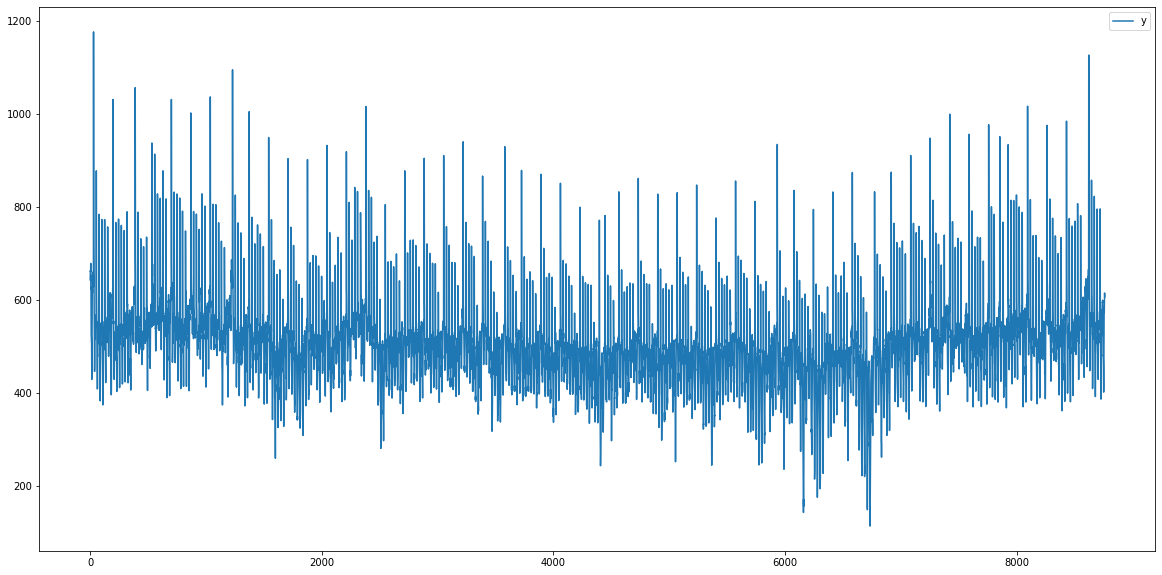

In [13]:
df_gas.plot(figsize=(20, 10))

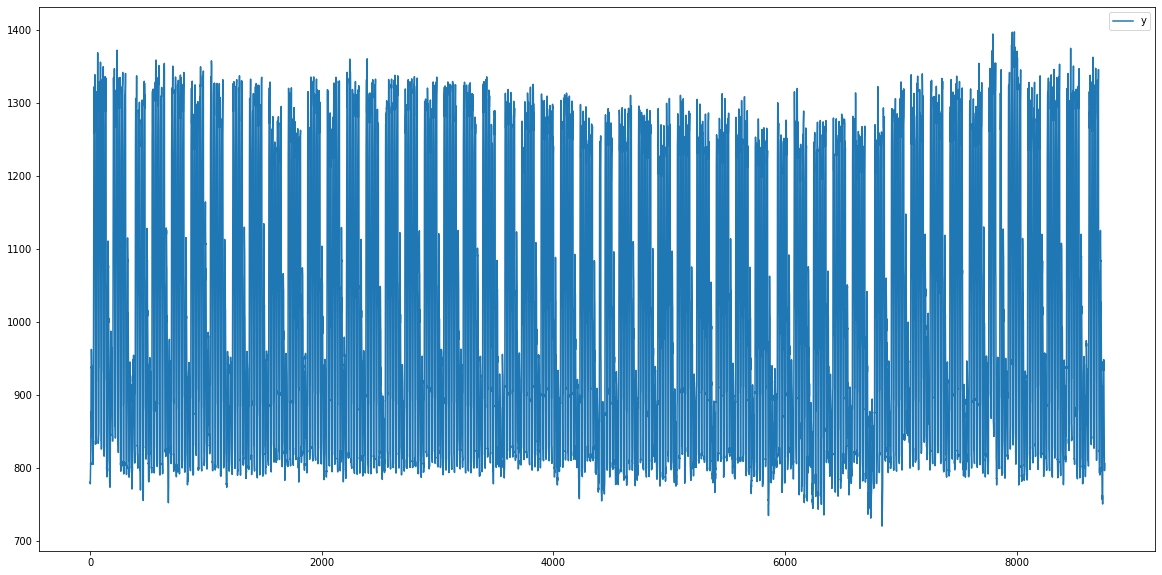

In [14]:
df_electric.plot(figsize=(20, 10))

### Log Scale설정

In [15]:
df_gas['y'] = np.log(df_gas['y'])
print(np.power(np.e, df_gas['y'][0]))

643.2391828349995


In [16]:
df_electric['y'] = np.log(df_electric['y'])
print(np.power(np.e,df_electric['y'][0]))

780.5059253059999


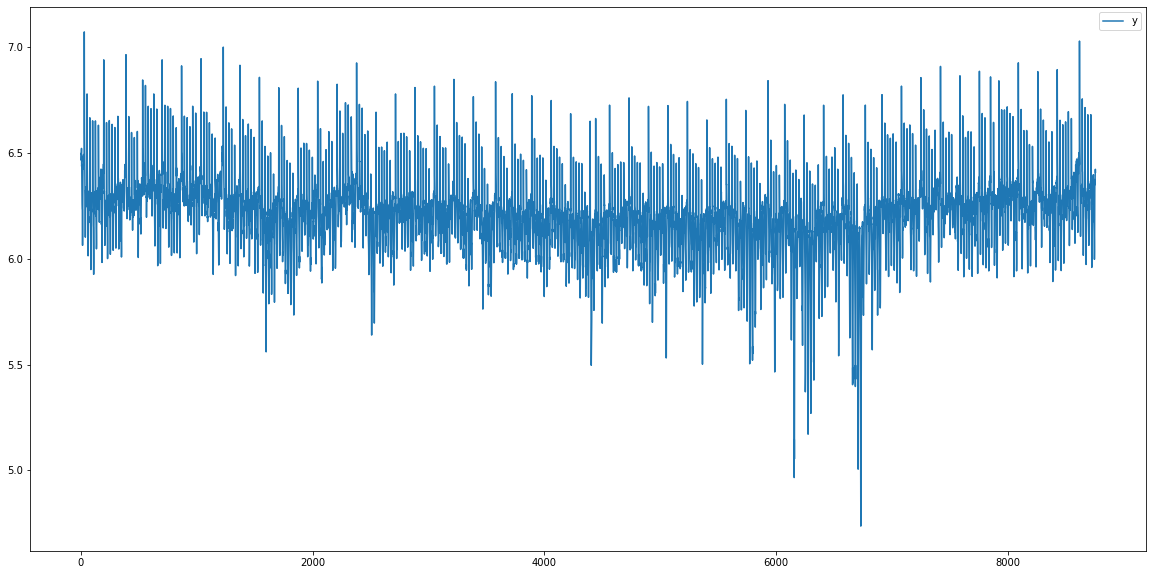

In [17]:
df_gas.plot(figsize=(20, 10))

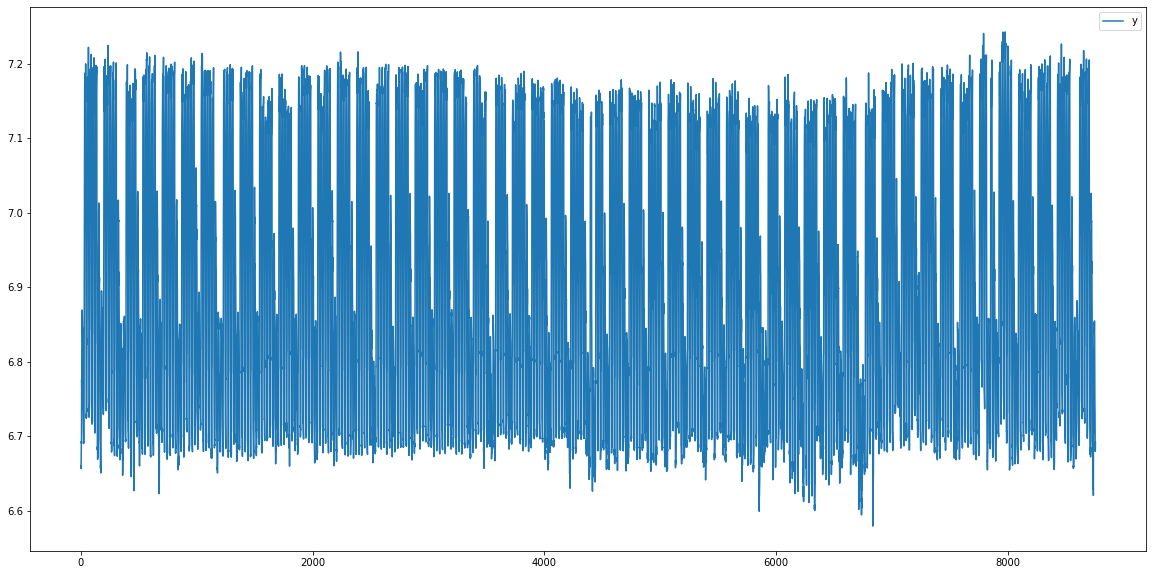

In [18]:
df_electric.plot(figsize=(20, 10))

## 2004년도의 1월부터 11월의 데이터를 활용해 12월을 예측
  - object 에서 datetime으로 구조체 변경
  - 2004년 1월 ~ 11월에 해당하는 데이터와 12월에 해당하는 데이터 분리

In [19]:
df_electric['ds'] = pd.to_datetime(df_electric['ds'])
df_gas['ds'] = pd.to_datetime(df_gas['ds']) # ds의 구조체가 object에서 datetime64로 변경
print(df_electric['ds'].head())
print(df_gas['ds'].head())

0   2004-01-01 01:00:00
1   2004-01-01 02:00:00
2   2004-01-01 03:00:00
3   2004-01-01 04:00:00
4   2004-01-01 05:00:00
Name: ds, dtype: datetime64[ns]
0   2004-01-01 01:00:00
1   2004-01-01 02:00:00
2   2004-01-01 03:00:00
3   2004-01-01 04:00:00
4   2004-01-01 05:00:00
Name: ds, dtype: datetime64[ns]


In [0]:
df11_gas = df_gas[df_gas['ds'] < datetime.datetime(2004, 12, 1, 0, 0, 0)]
df11_electric = df_electric[df_electric['ds'] < datetime.datetime(2004, 12, 1, 0, 0, 0)]

In [21]:
print(df_gas.shape)
print(df11_gas.shape)
print(df_electric.shape)
print(df11_electric.shape)

(8760, 2)
(8016, 2)
(8760, 2)
(8016, 2)


### Prohet 모델에 데이터 fitting

In [22]:
m_gas = ph.Prophet()
m_gas.fit(df11_gas)

m_electric = ph.Prophet()
m_electric.fit(df11_electric)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [23]:
m_gas.history

,ds,y,floor,t,y_scaled
0,2004-01-01 00:00:00,6.489368,0,0.000000,0.917918
1,2004-01-01 01:00:00,6.466517,0,0.000124,0.914685
2,2004-01-01 02:00:00,6.485771,0,0.000249,0.917409
3,2004-01-01 03:00:00,6.496585,0,0.000373,0.918938
4,2004-01-01 04:00:00,6.492920,0,0.000498,0.918420
...,...,...,...,...,...
8011,2004-11-30 19:00:00,6.280480,0,0.999502,0.888371
8012,2004-11-30 20:00:00,6.251667,0,0.999627,0.884295
8013,2004-11-30 21:00:00,6.331139,0,0.999751,0.895536
8014,2004-11-30 22:00:00,6.303026,0,0.999876,0.891560


In [24]:
m_electric.history

,ds,y,floor,t,y_scaled
0,2004-01-01 00:00:00,6.697011,0,0.000000,0.924698
1,2004-01-01 01:00:00,6.659942,0,0.000124,0.919580
2,2004-01-01 02:00:00,6.656905,0,0.000249,0.919160
3,2004-01-01 03:00:00,6.668764,0,0.000373,0.920798
4,2004-01-01 04:00:00,6.681739,0,0.000498,0.922590
...,...,...,...,...,...
8011,2004-11-30 19:00:00,6.963178,0,0.999502,0.961450
8012,2004-11-30 20:00:00,6.964241,0,0.999627,0.961596
8013,2004-11-30 21:00:00,6.835858,0,0.999751,0.943870
8014,2004-11-30 22:00:00,6.803974,0,0.999876,0.939467


### Gas 데이터 예측모델링
  - fitting_model : m_gas
  - 데이터 풀 생성 : future_gas
  - prediction 결과물 : forecast_gas

In [25]:
future_gas = m_gas.make_future_dataframe(freq='H',periods=744) # Next 24x31 = 744 hours or 31 days. freq의 단위를 시간으로 설정함
print(future_gas)

                      ds
0    2004-01-01 00:00:00
1    2004-01-01 01:00:00
2    2004-01-01 02:00:00
3    2004-01-01 03:00:00
4    2004-01-01 04:00:00
...                  ...
8755 2004-12-31 19:00:00
8756 2004-12-31 20:00:00
8757 2004-12-31 21:00:00
8758 2004-12-31 22:00:00
8759 2004-12-31 23:00:00

[8760 rows x 1 columns]


In [26]:
forecast_gas= m_gas.predict(future_gas)
print(forecast_gas.columns)
forecast_gas.head()

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2004-01-01 00:00:00,6.301197,6.220798,6.505452,6.301197,6.301197,0.068151,0.068151,0.068151,0.063673,0.063673,0.063673,0.004478,0.004478,0.004478,0.0,0.0,0.0,6.369347
1,2004-01-01 01:00:00,6.301166,6.213363,6.501887,6.301166,6.301166,0.053371,0.053371,0.053371,0.048855,0.048855,0.048855,0.004516,0.004516,0.004516,0.0,0.0,0.0,6.354538
2,2004-01-01 02:00:00,6.301136,6.212720,6.501722,6.301136,6.301136,0.052592,0.052592,0.052592,0.048237,0.048237,0.048237,0.004354,0.004354,0.004354,0.0,0.0,0.0,6.353728
3,2004-01-01 03:00:00,6.301106,6.248709,6.525244,6.301106,6.301106,0.081832,0.081832,0.081832,0.077836,0.077836,0.077836,0.003996,0.003996,0.003996,0.0,0.0,0.0,6.382938
4,2004-01-01 04:00:00,6.301076,6.292588,6.570275,6.301076,6.301076,0.133026,0.133026,0.133026,0.129578,0.129578,0.129578,0.003449,0.003449,0.003449,0.0,0.0,0.0,6.434102


In [27]:
forecast_gas[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

# forecast_gas.plot(figsize= (20,10))

,ds,yhat,yhat_lower,yhat_upper
8755,2004-12-31 19:00:00,6.409385,6.216039,6.606436
8756,2004-12-31 20:00:00,6.451762,6.259158,6.653427
8757,2004-12-31 21:00:00,6.484062,6.298091,6.678465
8758,2004-12-31 22:00:00,6.509225,6.318166,6.709004
8759,2004-12-31 23:00:00,6.521824,6.332776,6.713424


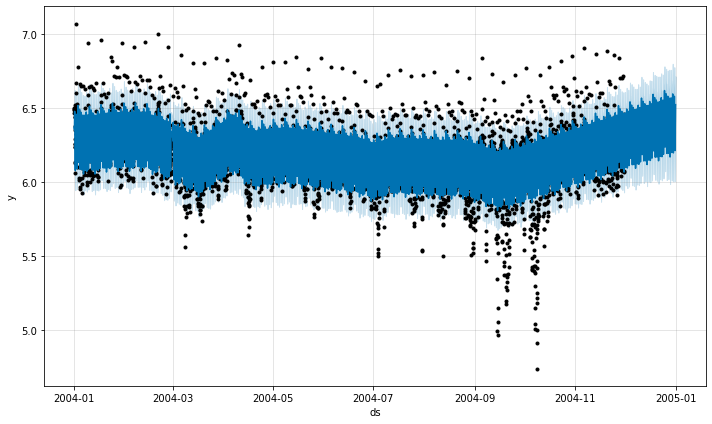

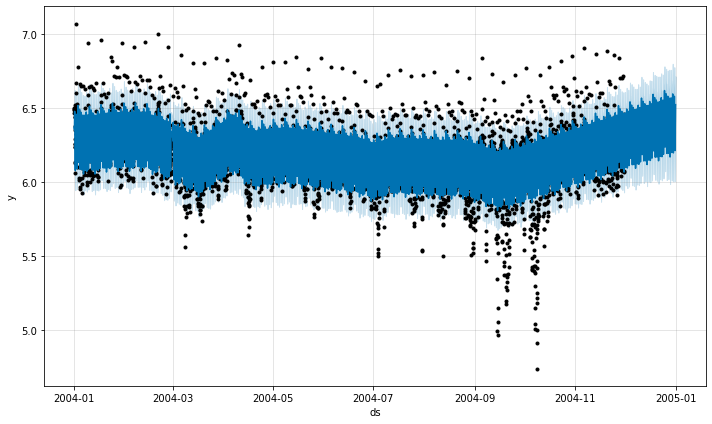

In [28]:
m_gas.plot(forecast_gas)

In [29]:
print(forecast_gas.shape)
print(forecast_gas.columns)

(8760, 19)
Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')


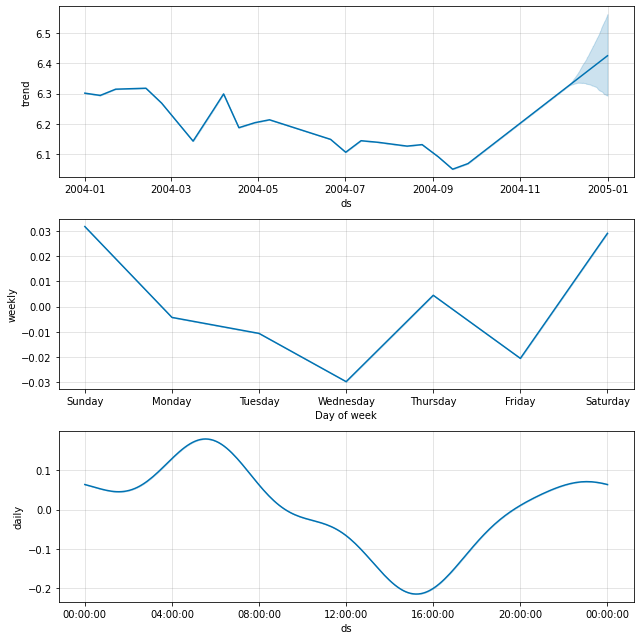

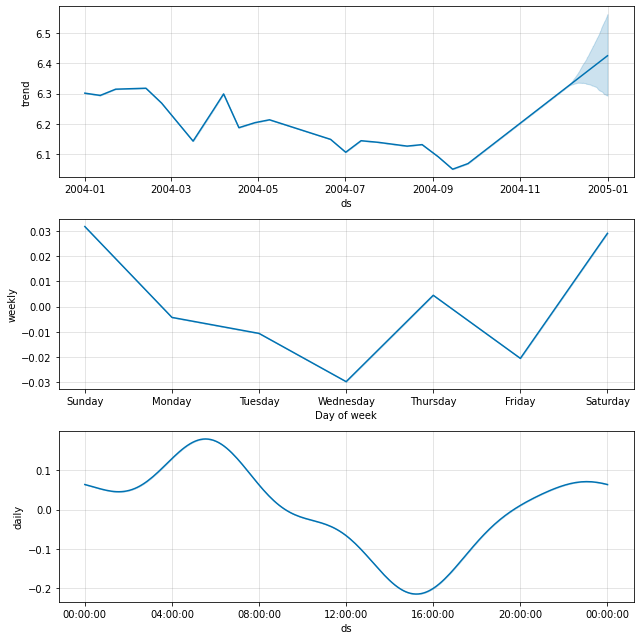

In [30]:
m_gas.plot_components(forecast_gas)

## Finding better scale for gas utilization

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


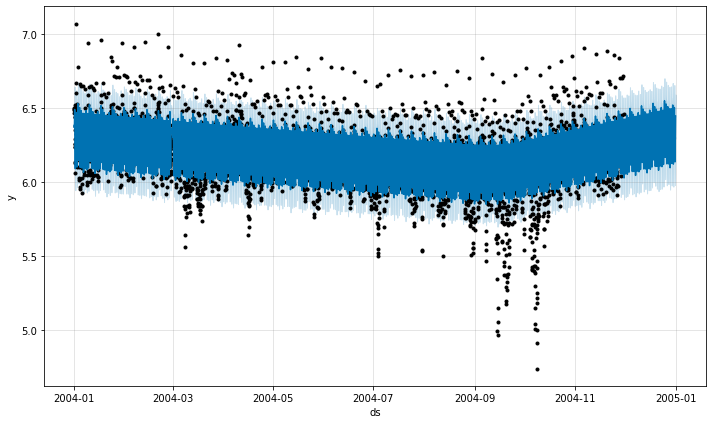

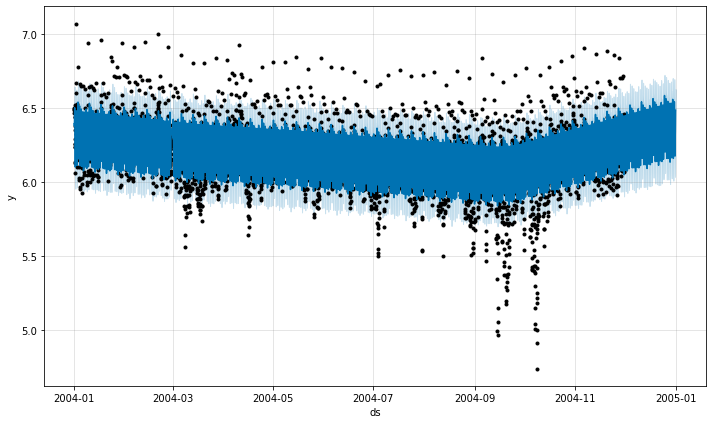

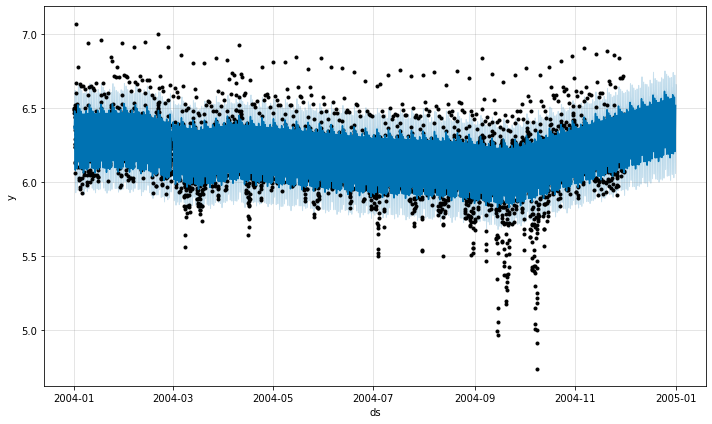

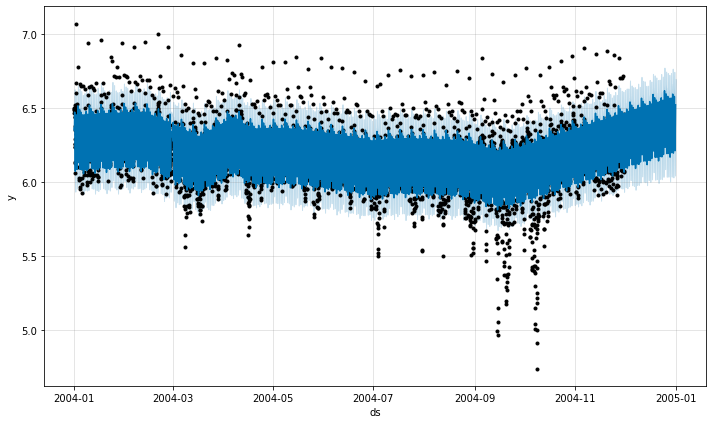

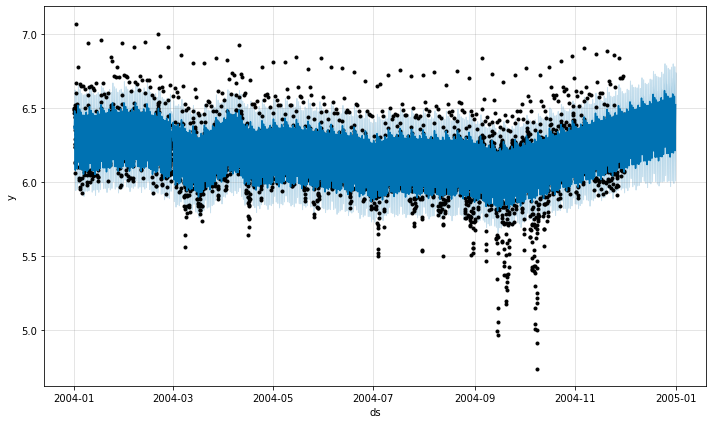

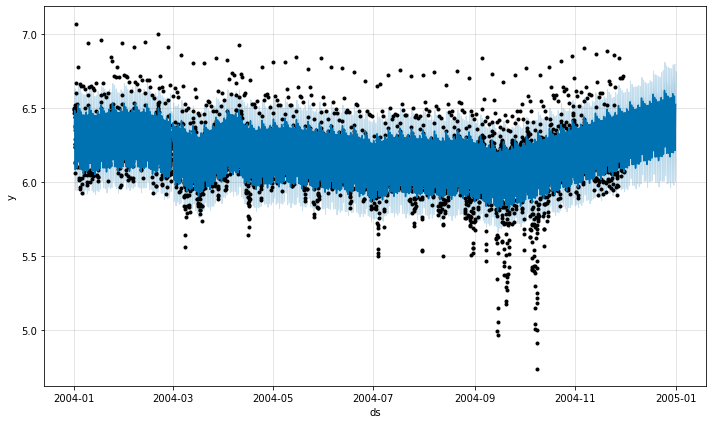

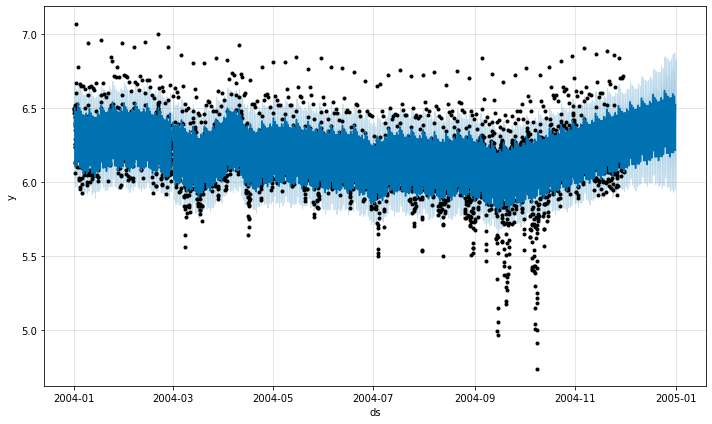

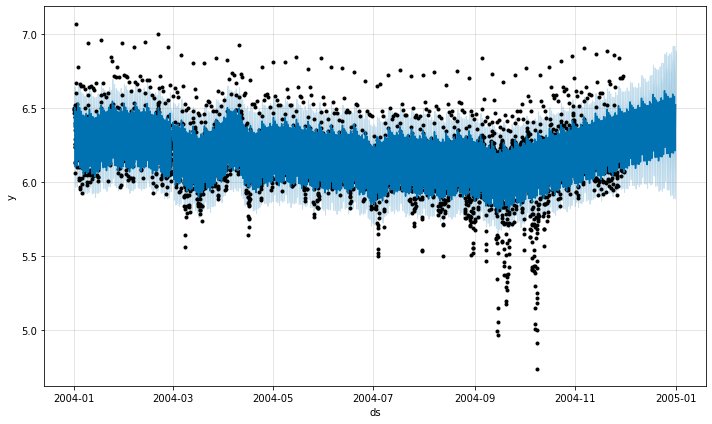

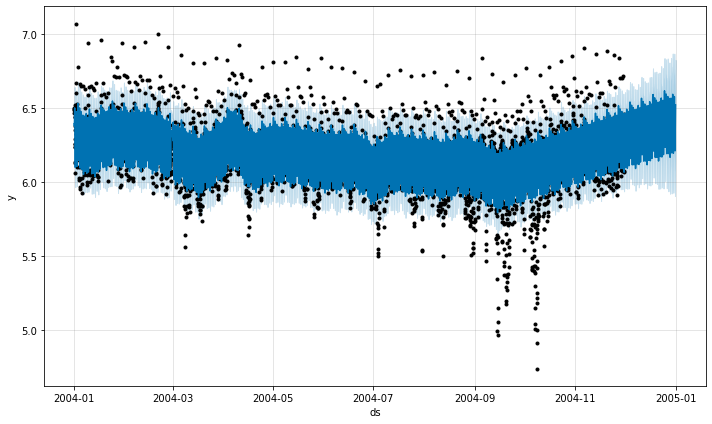

In [31]:
##If the trend changes are being overfit (too much flexibility) or underfit (not enough flexiblity), you can adjust the strength of the sparse prior using the input argument changepoint_prior_scale.

# Setting future for one month
future_gas_ch = m_gas.make_future_dataframe(freq='H', periods=744) # Next 31 days

changepoint_prior_scales = [0.001, 0.003, 0.009, 0.03, 0.06, 0.09, 0.3, 0.6, 0.9] # changepoint_prior_scale의 값이 클수록 모델 자체의 자유도에 책임을 위임한다는 얘기

# Decreasing changepoint_prior_scale values will make the trend less flexible:
for i in changepoint_prior_scales:
  m_gas_i = ph.Prophet(changepoint_prior_scale=i)
  forecast_gas_i = m_gas_i.fit(df11_gas).predict(future_gas_ch)
  m_gas_i.plot(forecast_gas_i);

In [0]:
#df_gas.set_index('ds', inplace=True)
#df_gas.plot()